<a href="https://colab.research.google.com/github/AdityaGadekar124/SKINVERSE/blob/main/Skinverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import shutil
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy.random import seed
seed(101)

# Use TensorFlow's random seed function
tf.random.set_seed(101)

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Enable inline plotting (automatically enabled in Google Colab)
%matplotlib inline


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.listdir('/content/drive/MyDrive/input')

['hmnist_28_28_L.csv',
 'hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'HAM10000_metadata.csv',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2']

In [6]:
base_dir = 'base_dir'
os.mkdir(base_dir)

In [7]:
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

In [8]:
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

In [9]:
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [10]:
df_data = pd.read_csv('/content/drive/MyDrive/input/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [11]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [12]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):

    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [13]:
df_data['duplicates'].value_counts()

,count
duplicates,
no_duplicates,5514
has_duplicates,4501


In [14]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [15]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape


(938, 8)

In [16]:
df_val['dx'].value_counts()

,count
dx,
nv,751
bkl,75
mel,39
bcc,30
akiec,26
vasc,11
df,6


In [17]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])

    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)

# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [18]:
df_train['dx'].value_counts()

,count
dx,
nv,5954
mel,1074
bkl,1024
bcc,484
akiec,301
vasc,131
df,109


In [19]:
df_val['dx'].value_counts()

,count
dx,
nv,751
bkl,75
mel,39
bcc,30
akiec,26
vasc,11
df,6


In [20]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [21]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/content/drive/MyDrive/input/HAM10000_images_part_1')
folder_2 = os.listdir('/content/drive/MyDrive/input/HAM10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)





In [22]:
# Transfer the val images

for image in val_list:

    fname = image + '.jpg'
    label = df_data.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/input/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/input/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [23]:

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [24]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [25]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:

    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)
# point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)
# Generate the augmented images and add them to the training folders

    ###########

    num_aug_images_wanted = 6000 # total number of images we want to have in each class

    ###########

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [26]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [27]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


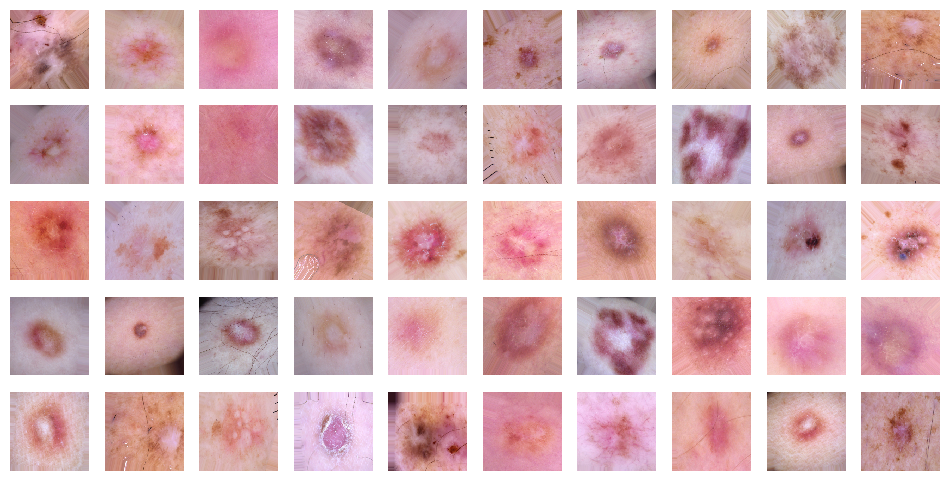

In [28]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

plots(imgs, titles=None) # titles=labels will display the image labels


In [29]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

In [30]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [31]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input) # Changed tensorflow to tf

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [32]:
# create a copy of a mobilenet model

mobile = tf.keras.applications.mobilenet.MobileNet() # Changed tensorflow to tf

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [34]:
type(mobile.layers)

list

In [35]:
# How many layers does MobileNet have?
len(mobile.layers)

91

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Extract features from MobileNet up to the correct layer
x = mobile.layers[-6].output

# Add a GlobalAveragePooling layer to convert 4D to 2D
x = GlobalAveragePooling2D()(x)  # Ensures correct shape

# Add Dropout for regularization
x = Dropout(0.25)(x)

# Final Dense layer with 7 output classes
predictions = Dense(7, activation='softmax')(x)

# Define new model
model = Model(inputs=mobile.input, outputs=predictions)


In [37]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,236,039 (12.34 MB)

 Trainable params: 3,214,151 (12.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [38]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [39]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [40]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [41]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [42]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}


In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define the checkpoint and learning rate scheduler
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=1e-5)

callbacks_list = [checkpoint, reduce_lr]

# Ensure steps are integers
train_steps = int(train_steps)
val_steps = int(val_steps)

# Train the model
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - categorical_accuracy: 0.4523 - loss: 2.1510 - top_2_accuracy: 0.6430 - top_3_accuracy: 0.7765
Epoch 1: val_top_3_accuracy improved from -inf to 0.93603, saving model to model.h5


908/908 ━━━━━━━━━━━━━━━━━━━━ 681s 741ms/step - categorical_accuracy: 0.4524 - loss: 2.1505 - top_2_accuracy: 0.6431 - top_3_accuracy: 0.7766 - val_categorical_accuracy: 0.8102 - val_loss: 0.8073 - val_top_2_accuracy: 0.8902 - val_top_3_accuracy: 0.9360 - learning_rate: 0.0100
Epoch 2/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - categorical_accuracy: 0.6024 - loss: 1.3151 - top_2_accuracy: 0.8002 - top_3_accuracy: 0.9033
Epoch 2: val_top_3_accuracy did not improve from 0.93603
908/908 ━━━━━━━━━━━━━━━━━━━━ 672s 740ms/step - categorical_accuracy: 0.6024 - loss: 1.3151 - top_2_accuracy: 0.8002 - top_3_accuracy: 0.9034 - val_categorical_accuracy: 0.3380 - val_loss: 2.7106 - val_top_2_accuracy: 0.6269 - val_top_3_accuracy: 0.8507 - learning_rate: 0.0100
Epoch 3/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - categorical_accuracy: 0.6667 - loss: 1.1035 - top_2_accuracy: 0.8465 - top_3_accuracy: 0.9394
Epoch 3: val_top_3_accuracy improved from 0.93603 to 0.96482, saving model to model.h5


908/908 ━━━━━━━━━━━━━━━━━━━━ 674s 743ms/step - categorical_accuracy: 0.6667 - loss: 1.1035 - top_2_accuracy: 0.8465 - top_3_accuracy: 0.9394 - val_categorical_accuracy: 0.8475 - val_loss: 0.4961 - val_top_2_accuracy: 0.9318 - val_top_3_accuracy: 0.9648 - learning_rate: 0.0100
Epoch 4/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - categorical_accuracy: 0.7016 - loss: 0.9914 - top_2_accuracy: 0.8720 - top_3_accuracy: 0.9505
Epoch 4: val_top_3_accuracy did not improve from 0.96482
908/908 ━━━━━━━━━━━━━━━━━━━━ 651s 717ms/step - categorical_accuracy: 0.7016 - loss: 0.9914 - top_2_accuracy: 0.8720 - top_3_accuracy: 0.9505 - val_categorical_accuracy: 0.8262 - val_loss: 0.7309 - val_top_2_accuracy: 0.8987 - val_top_3_accuracy: 0.9563 - learning_rate: 0.0100
Epoch 5/30
225/908 ━━━━━━━━━━━━━━━━━━━━ 8:23 737ms/step - categorical_accuracy: 0.7189 - loss: 0.8956 - top_2_accuracy: 0.8877 - top_3_accuracy: 0.9677

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_top_3_accuracy improved from 0.96482 to 0.97548, saving model to model.h5


908/908 ━━━━━━━━━━━━━━━━━━━━ 212s 233ms/step - categorical_accuracy: 0.7177 - loss: 0.8977 - top_2_accuracy: 0.8909 - top_3_accuracy: 0.9683 - val_categorical_accuracy: 0.8412 - val_loss: 0.4460 - val_top_2_accuracy: 0.9403 - val_top_3_accuracy: 0.9755 - learning_rate: 0.0100
Epoch 6/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - categorical_accuracy: 0.7186 - loss: 0.9295 - top_2_accuracy: 0.8923 - top_3_accuracy: 0.9575
Epoch 6: val_top_3_accuracy did not improve from 0.97548
908/908 ━━━━━━━━━━━━━━━━━━━━ 731s 805ms/step - categorical_accuracy: 0.7186 - loss: 0.9294 - top_2_accuracy: 0.8923 - top_3_accuracy: 0.9575 - val_categorical_accuracy: 0.8369 - val_loss: 0.5553 - val_top_2_accuracy: 0.9168 - val_top_3_accuracy: 0.9542 - learning_rate: 0.0100
Epoch 7/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - categorical_accuracy: 0.7314 - loss: 0.8812 - top_2_accuracy: 0.8977 - top_3_accuracy: 0.9659
Epoch 7: val_top_3_accuracy improved from 0.97548 to 0.97655, saving model to model.h5


908/908 ━━━━━━━━━━━━━━━━━━━━ 746s 821ms/step - categorical_accuracy: 0.7314 - loss: 0.8812 - top_2_accuracy: 0.8977 - top_3_accuracy: 0.9659 - val_categorical_accuracy: 0.8625 - val_loss: 0.4298 - val_top_2_accuracy: 0.9456 - val_top_3_accuracy: 0.9765 - learning_rate: 0.0100
Epoch 8/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - categorical_accuracy: 0.7552 - loss: 0.8069 - top_2_accuracy: 0.9085 - top_3_accuracy: 0.9683
Epoch 8: val_top_3_accuracy did not improve from 0.97655
908/908 ━━━━━━━━━━━━━━━━━━━━ 745s 821ms/step - categorical_accuracy: 0.7552 - loss: 0.8069 - top_2_accuracy: 0.9085 - top_3_accuracy: 0.9683 - val_categorical_accuracy: 0.7804 - val_loss: 0.6500 - val_top_2_accuracy: 0.9115 - val_top_3_accuracy: 0.9627 - learning_rate: 0.0100
Epoch 9/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - categorical_accuracy: 0.7698 - loss: 0.7770 - top_2_accuracy: 0.9157 - top_3_accuracy: 0.9746
Epoch 9: val_top_3_accuracy did not improve from 0.97655

Epoch 9: ReduceLROnPlateau redu

908/908 ━━━━━━━━━━━━━━━━━━━━ 250s 275ms/step - categorical_accuracy: 0.7711 - loss: 0.7131 - top_2_accuracy: 0.9273 - top_3_accuracy: 0.9758 - val_categorical_accuracy: 0.8635 - val_loss: 0.3992 - val_top_2_accuracy: 0.9552 - val_top_3_accuracy: 0.9861 - learning_rate: 0.0050
Epoch 11/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - categorical_accuracy: 0.8211 - loss: 0.5779 - top_2_accuracy: 0.9405 - top_3_accuracy: 0.9872
Epoch 11: val_top_3_accuracy did not improve from 0.98614
908/908 ━━━━━━━━━━━━━━━━━━━━ 754s 804ms/step - categorical_accuracy: 0.8211 - loss: 0.5779 - top_2_accuracy: 0.9405 - top_3_accuracy: 0.9872 - val_categorical_accuracy: 0.9019 - val_loss: 0.3348 - val_top_2_accuracy: 0.9701 - val_top_3_accuracy: 0.9840 - learning_rate: 0.0050
Epoch 12/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - categorical_accuracy: 0.8367 - loss: 0.5385 - top_2_accuracy: 0.9542 - top_3_accuracy: 0.9870
Epoch 12: val_top_3_accuracy did not improve from 0.98614

Epoch 12: ReduceLROnPlateau

908/908 ━━━━━━━━━━━━━━━━━━━━ 734s 809ms/step - categorical_accuracy: 0.8657 - loss: 0.4262 - top_2_accuracy: 0.9679 - top_3_accuracy: 0.9936 - val_categorical_accuracy: 0.8870 - val_loss: 0.3533 - val_top_2_accuracy: 0.9701 - val_top_3_accuracy: 0.9883 - learning_rate: 0.0025
Epoch 15/30
225/908 ━━━━━━━━━━━━━━━━━━━━ 7:33 665ms/step - categorical_accuracy: 0.8643 - loss: 0.4071 - top_2_accuracy: 0.9650 - top_3_accuracy: 0.9976
Epoch 15: val_top_3_accuracy improved from 0.98827 to 0.98934, saving model to model.h5


908/908 ━━━━━━━━━━━━━━━━━━━━ 232s 255ms/step - categorical_accuracy: 0.8764 - loss: 0.3842 - top_2_accuracy: 0.9719 - top_3_accuracy: 0.9974 - val_categorical_accuracy: 0.8945 - val_loss: 0.3238 - val_top_2_accuracy: 0.9744 - val_top_3_accuracy: 0.9893 - learning_rate: 0.0025
Epoch 16/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - categorical_accuracy: 0.8871 - loss: 0.3787 - top_2_accuracy: 0.9725 - top_3_accuracy: 0.9963
Epoch 16: val_top_3_accuracy did not improve from 0.98934
908/908 ━━━━━━━━━━━━━━━━━━━━ 729s 803ms/step - categorical_accuracy: 0.8871 - loss: 0.3788 - top_2_accuracy: 0.9725 - top_3_accuracy: 0.9963 - val_categorical_accuracy: 0.8657 - val_loss: 0.3782 - val_top_2_accuracy: 0.9595 - val_top_3_accuracy: 0.9840 - learning_rate: 0.0025
Epoch 17/30
908/908 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - categorical_accuracy: 0.8889 - loss: 0.3633 - top_2_accuracy: 0.9739 - top_3_accuracy: 0.9950
Epoch 17: val_top_3_accuracy did not improve from 0.98934

Epoch 17: ReduceLROnPlateau

908/908 ━━━━━━━━━━━━━━━━━━━━ 664s 732ms/step - categorical_accuracy: 0.9270 - loss: 0.2274 - top_2_accuracy: 0.9867 - top_3_accuracy: 0.9990 - val_categorical_accuracy: 0.8945 - val_loss: 0.3452 - val_top_2_accuracy: 0.9723 - val_top_3_accuracy: 0.9904 - learning_rate: 3.9062e-05
Epoch 30/30
225/908 ━━━━━━━━━━━━━━━━━━━━ 8:08 716ms/step - categorical_accuracy: 0.9323 - loss: 0.2243 - top_2_accuracy: 0.9865 - top_3_accuracy: 0.9953
Epoch 30: val_top_3_accuracy did not improve from 0.99041
908/908 ━━━━━━━━━━━━━━━━━━━━ 207s 227ms/step - categorical_accuracy: 0.9271 - loss: 0.2374 - top_2_accuracy: 0.9866 - top_3_accuracy: 0.9975 - val_categorical_accuracy: 0.8934 - val_loss: 0.3445 - val_top_2_accuracy: 0.9701 - val_top_3_accuracy: 0.9893 - learning_rate: 3.9062e-05


In [44]:
model.metrics_names

['loss', 'compile_metrics']

In [45]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches,
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

938/938 ━━━━━━━━━━━━━━━━━━━━ 55s 59ms/step - categorical_accuracy: 0.7847 - loss: 0.7209 - top_2_accuracy: 0.9193 - top_3_accuracy: 0.9648
val_loss: 0.34446215629577637
val_cat_acc: 0.8933901786804199
val_top_2_acc: 0.9701492786407471
val_top_3_acc: 0.9893389940261841


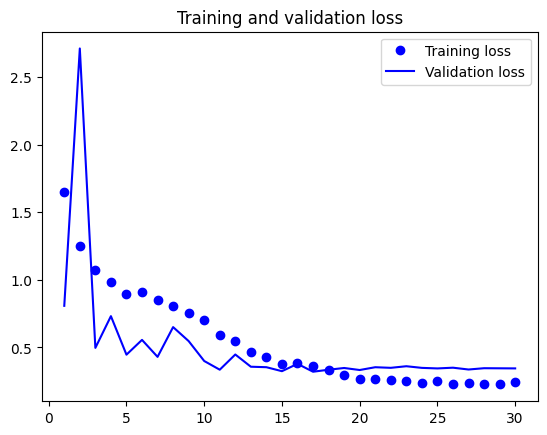

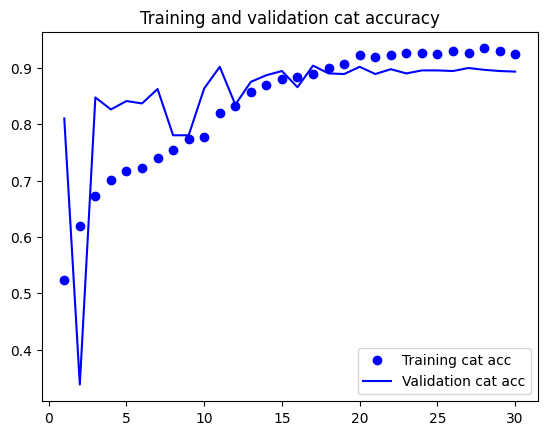

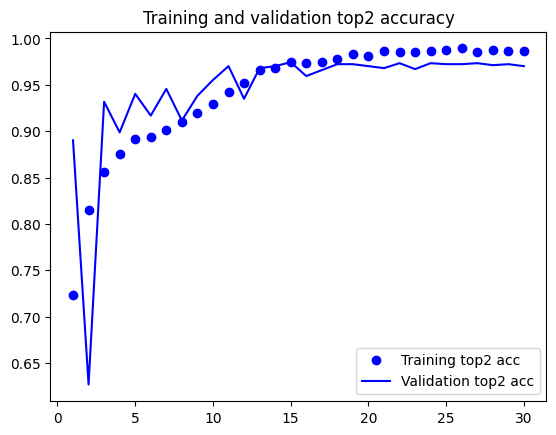

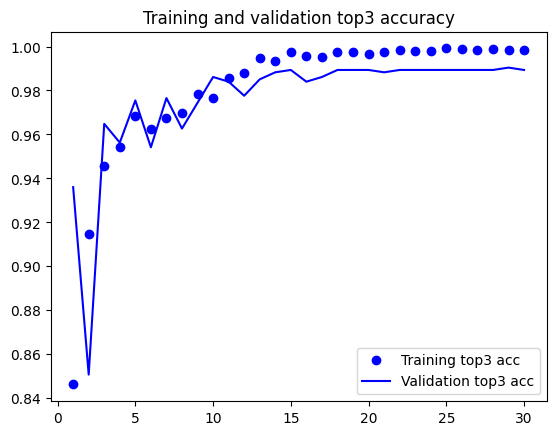

In [46]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [47]:

test_labels = test_batches.classes

In [48]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [49]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [50]:
# make a prediction
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

938/938 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step


In [51]:
predictions.shape

(938, 7)

In [52]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [53]:
test_labels.shape

(938,)

In [54]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[ 15   3   4   0   2   2   0]
 [  1  20   4   0   2   2   1]
 [  1   0  46   1  11  16   0]
 [  0   0   0   3   0   3   0]
 [  0   0   2   0  28   9   0]
 [  2   6   6   1  19 716   1]
 [  0   0   0   0   0   1  10]]


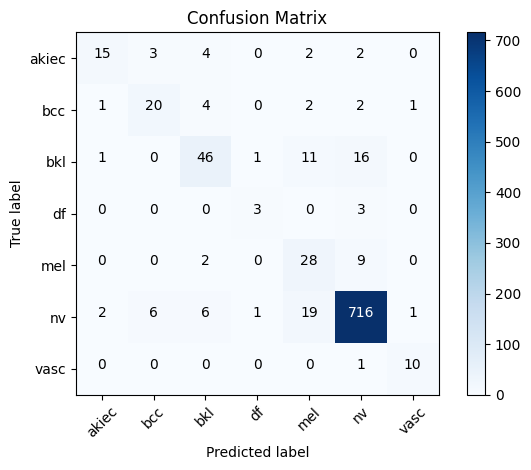

In [55]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [56]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [57]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.79      0.58      0.67        26
         bcc       0.69      0.67      0.68        30
         bkl       0.74      0.61      0.67        75
          df       0.60      0.50      0.55         6
         mel       0.45      0.72      0.55        39
          nv       0.96      0.95      0.95       751
        vasc       0.83      0.91      0.87        11

    accuracy                           0.89       938
   macro avg       0.72      0.71      0.71       938
weighted avg       0.90      0.89      0.89       938



**Distribution of Classes:**
Visualization: Bar chart
Purpose: To see the distribution of different skin cancer types in the dataset (akiec, bcc, bkl, df, mel, nv, vasc).

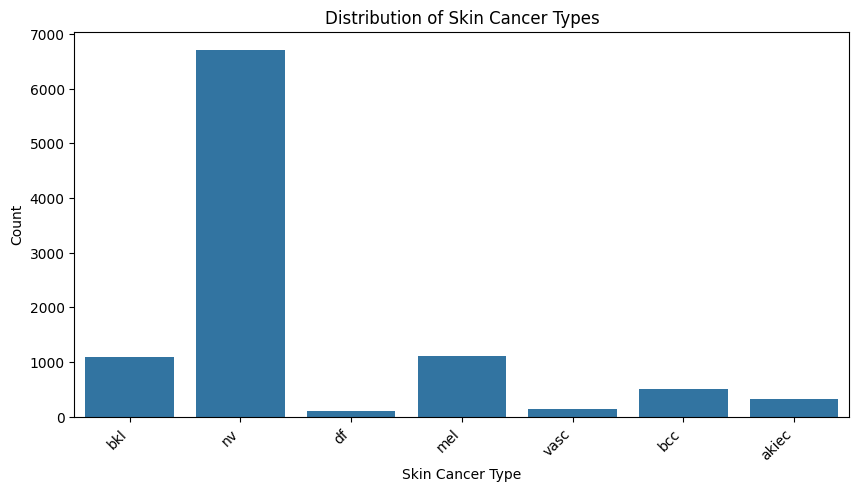

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df_data' is your DataFrame with the 'dx' column for skin cancer types

plt.figure(figsize=(10, 5))
sns.countplot(x='dx', data=df_data)
plt.title('Distribution of Skin Cancer Types')
plt.xlabel('Skin Cancer Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


**Sample Images with Predictions:**

**Visualization**: Grid of images with predicted labels

**Purpose**: To visually inspect the model's predictions on a subset of images and understand its strengths and weaknesses.

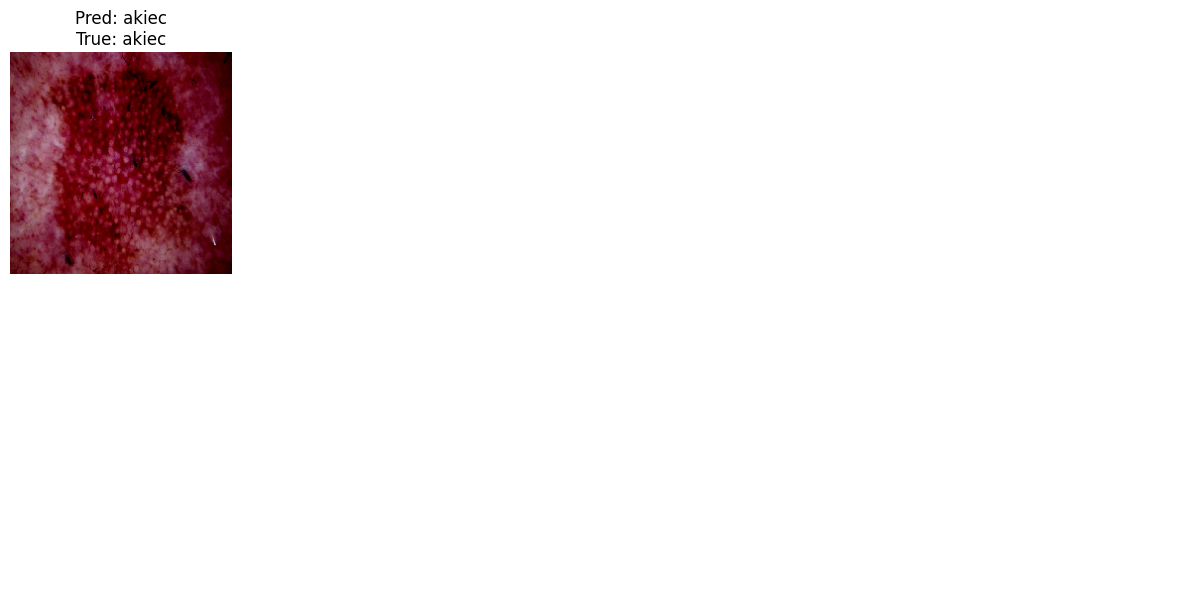

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test_batches' is your data generator and 'model' is your trained model

# Get a batch of test images and their true labels
imgs, labels = next(test_batches)

# Get model predictions for the batch
predictions = model.predict(imgs, verbose=0)  # Suppress prediction output

# Get predicted and true labels for the batch
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels, axis=1)

# Number of images in the batch
num_images = imgs.shape[0]

# Ensure that the number of subplots does not exceed the number of images in the batch
nrows, ncols = 2, 5
num_plots = nrows * ncols

# Adjust the number of plots if there are fewer images
num_plots = min(num_plots, num_images)

# Display a grid of images with predictions
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))

# Flatten the axes array
axes = axes.flat

for i in range(num_plots):
    # Display image with proper clipping to avoid warning
    ax = axes[i]
    ax.imshow(np.clip(imgs[i], 0, 1))  # Ensure values are within the [0, 1] range
    ax.axis('off')

    # Set title with prediction and true label
    ax.set_title(f"Pred: {cm_plot_labels[predicted_labels[i]]}\nTrue: {cm_plot_labels[true_labels[i]]}")

# Turn off any remaining unused axes
for j in range(num_plots, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


**Data Augmentation Examples**:

**Visualization**: Grid of original and augmented images

**Purpose**: To showcase the effect of different data augmentation techniques applied to the training images.

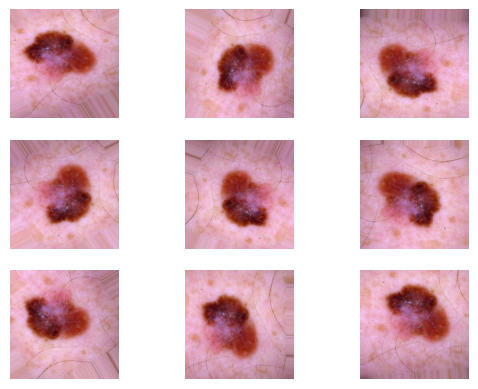

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import if not already imported

# Create an ImageDataGenerator with the desired augmentation settings
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load a sample image
img_path = 'base_dir/val_dir/mel/ISIC_0024967.jpg'  # Replace with a sample image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Load image using Keras
img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert to NumPy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

# Generate augmented images
i = 0
for batch in datagen.flow(img_array, batch_size=1):
    plt.subplot(3, 3, i + 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))  # Display image using Keras
    plt.axis('off')
    i += 1
    if i % 9 == 0:
        break  # Display 9 augmented images

plt.show()